# Practica Fisiología de semillas
Fisiología Vegetal - 2024-01<br>
__Hans D. Escobar H.__

Tratamientos:

| Tratamiento | Ensayo |
| :-: | :-: |
| t0 | Control |
| t1 | Escarificación mecánica |
| t2 | Escarificación ácida - H₂SO₄ 5% |
| t3 | Escarificación ácida - H₂SO₄ 10% |
| t4 | Alta temperatura - 5s |
| t5 | Alta temperatura - 50s |
| t6a | Luz azul |
| t6b | Luz roja |

In [4]:
########## Environment Set Up ##########

source("germination_curves.R")



Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser



--------------------------------------------------------------------------------
Welcome to germinationmetrics version 0.1.8


# To know how to use this package type:
  browseVignettes(package = 'germinationmetrics')
  for the package vignette.

# To know whats new in this version type:
  news(package='germinationmetrics')
  for the NEWS file.

# To cite the methods in the package type:
  citation(package='germinationmetrics')

# To suppress this message use:
  suppressPackageStartupMessages(library(germinationmetrics))
--------------------------------------------------------------------------------




## 1. Cargar datos

In [2]:
########## Load Data ##########

data_path <- "../Data/germination.tsv"
data <- read.delim(
  data_path,
  row.names = 1,
  colClasses = c(rep("factor", 3), rep("numeric", 9))
)

new_levels <- as.character(data$Treatment)
new_levels[new_levels == "t0"] <- "Control"
data[["Treatment"]] <- as.factor(new_levels)

########## Set Globals ##########

time_interval_names <- colnames(data)[3:10]
time_intervals <- sapply(
  strsplit(time_interval_names, split = "D"),
  FUN = function(x) {
    strtoi(x[2], base = 10)
  }
)
param_names <- c("a", "b", "c", "y0", "t50.Germinated", "Uniformity")
treatment_colors <- c(
  "Control" = "#2f2f2f",
  "t1" = "#5ad45a",
  "t2" = "#27aeef",
  "t3" = "#dc0ab4",
  "t4" = "#00bfa0",
  "t5" = "#ffa300",
  "t6a" = "#1a53ff",
  "t6b" = "#e60049"
)

comparisons <- list(
  scarification = c("Control", "t1", "t2", "t3"),
  temperature = c("Control", "t4", "t5"),
  light = c("Control", "t6a", "t6b")
)

statistics_prefixes <- list(
  Mean = ".Mean",
  StdError = ".StdError"
)

for_statistical_analysis <- c(
  "a",
  "t50.Germinated",
  "Uniformity"
)

# Raw data view
cbind(data, Total_Germinated = apply(
  data[time_interval_names], 1, sum
))


,Treatment,Replicate,D2,D4,D7,D9,D11,D14,D18,D22,Total_Seeds,Total_Germinated
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
t0R1,Control,1,0,0,0,0,0,29,10,6,50,45
t0R2,Control,2,0,0,0,0,3,32,7,3,50,45
t0R3,Control,3,0,0,0,0,4,28,10,4,50,46
t1R1,t1,1,0,0,0,0,0,28,14,1,50,43
t1R2,t1,2,0,0,0,0,0,17,13,5,50,35
t1R3,t1,3,0,0,0,0,3,18,8,3,50,32
t2R1,t2,1,0,0,0,0,15,23,0,0,50,38
t2R2,t2,2,0,0,0,0,7,33,0,0,50,40
t2R3,t2,3,0,0,0,0,16,16,0,0,50,32


## 2. Ajuste al modelo de cuatro parámetros de Hill

$$y = y_0 + \frac{a \cdot x^b}{c^b + x^b}$$

In [3]:
# ❗❗❗ Notice intervals are not uniform
old_warning <- getOption("warn")
options(warn = -1)

fits <- FourPHFfit.bulk(
  data,
  total.seeds.col = "Total_Seeds",
  counts.intervals.cols = time_interval_names,
  intervals = time_intervals,
  partial = TRUE,
  tmax = 60,
  tries = 10,
  # Minimum  and maximum germination percentage value for computing uniformity.
  umin = 10,
  umax = 90,
)

options(warn = old_warning)

cat("No convergieron en la regresión:")
fits[fits$Fit_isConv == FALSE, c("Treatment", "Replicate")]


No convergieron en la regresión:

,Treatment,Replicate
,<fct>,<fct>
7,t2,1
8,t2,2
13,t4,1
15,t4,3
19,t6a,1
20,t6a,2


### 2.1. Explorando ajuste a curva de cuatro parámetros de Hill

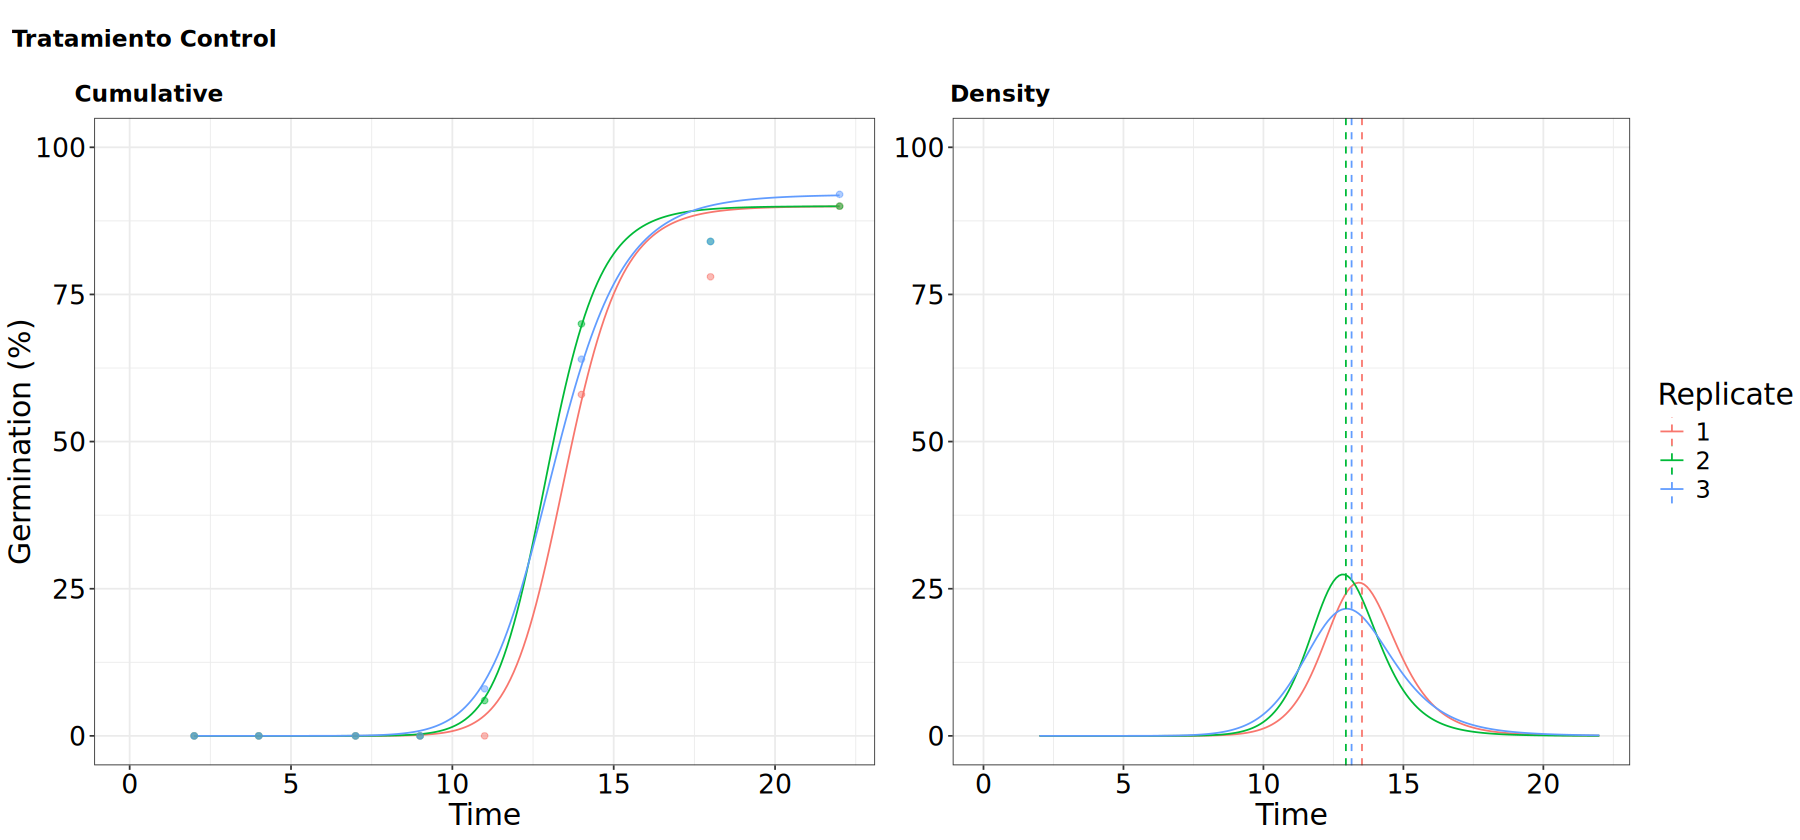

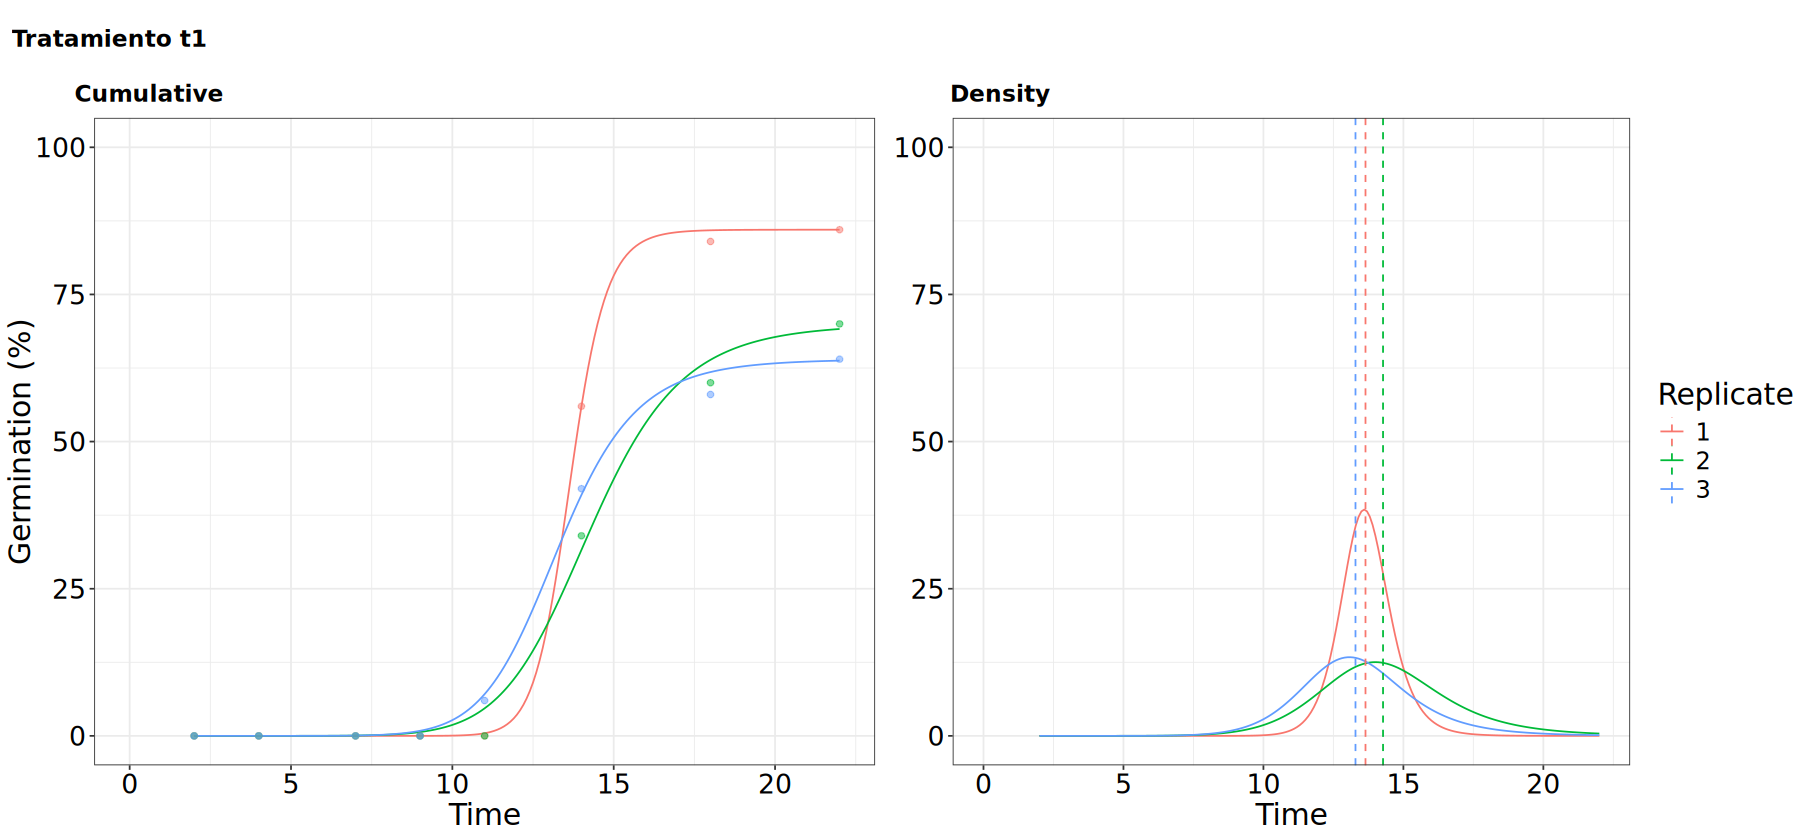

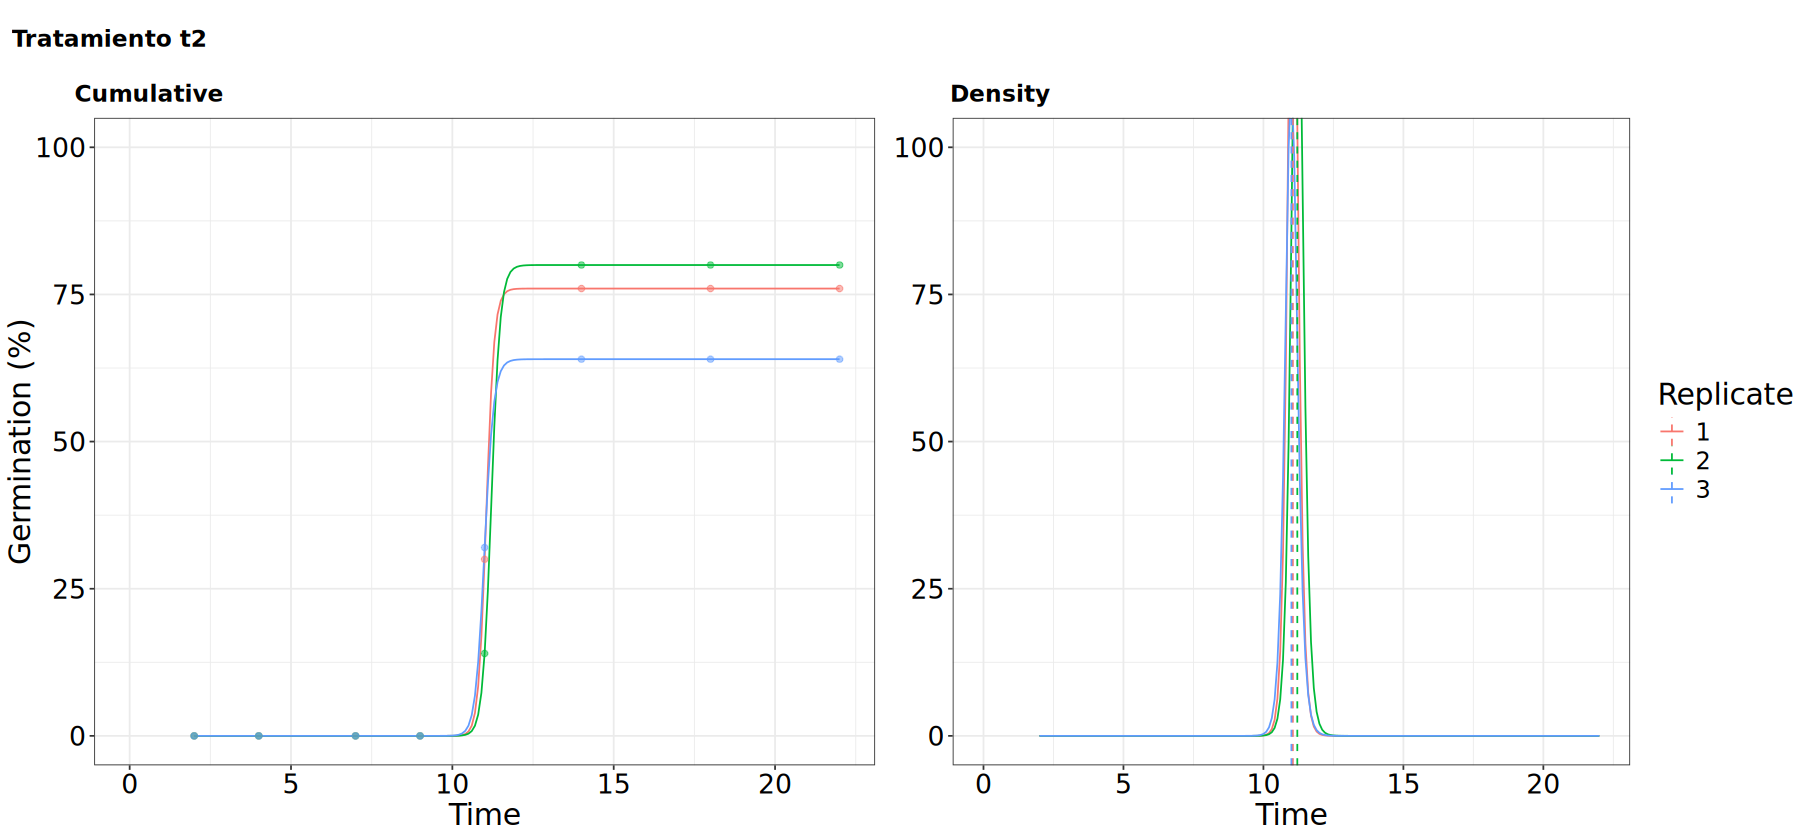

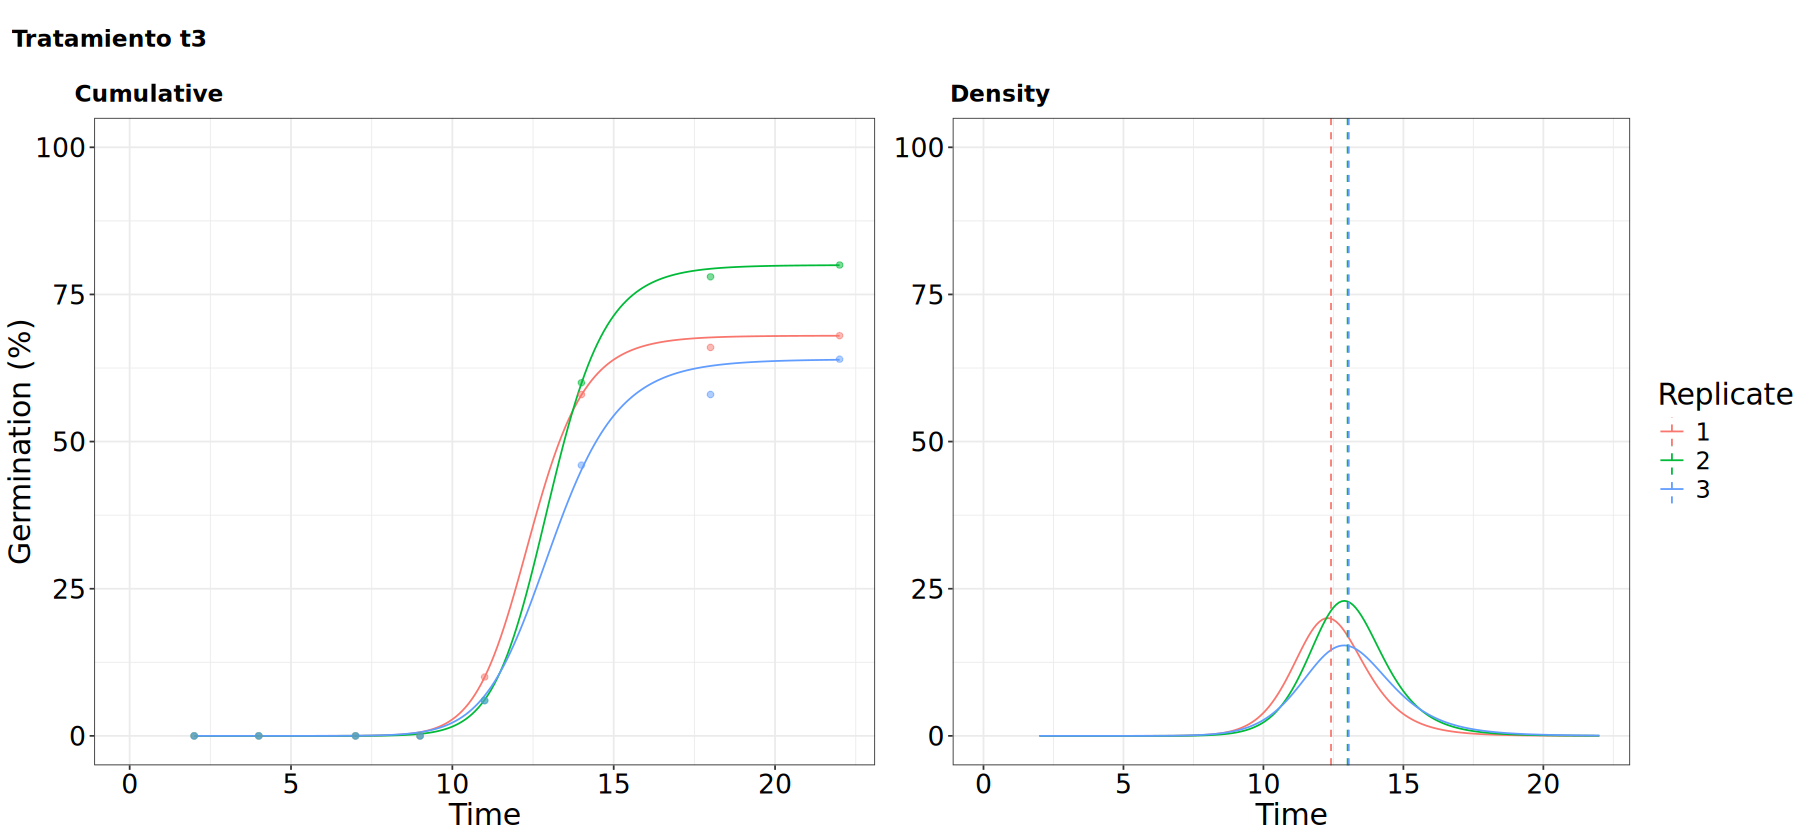

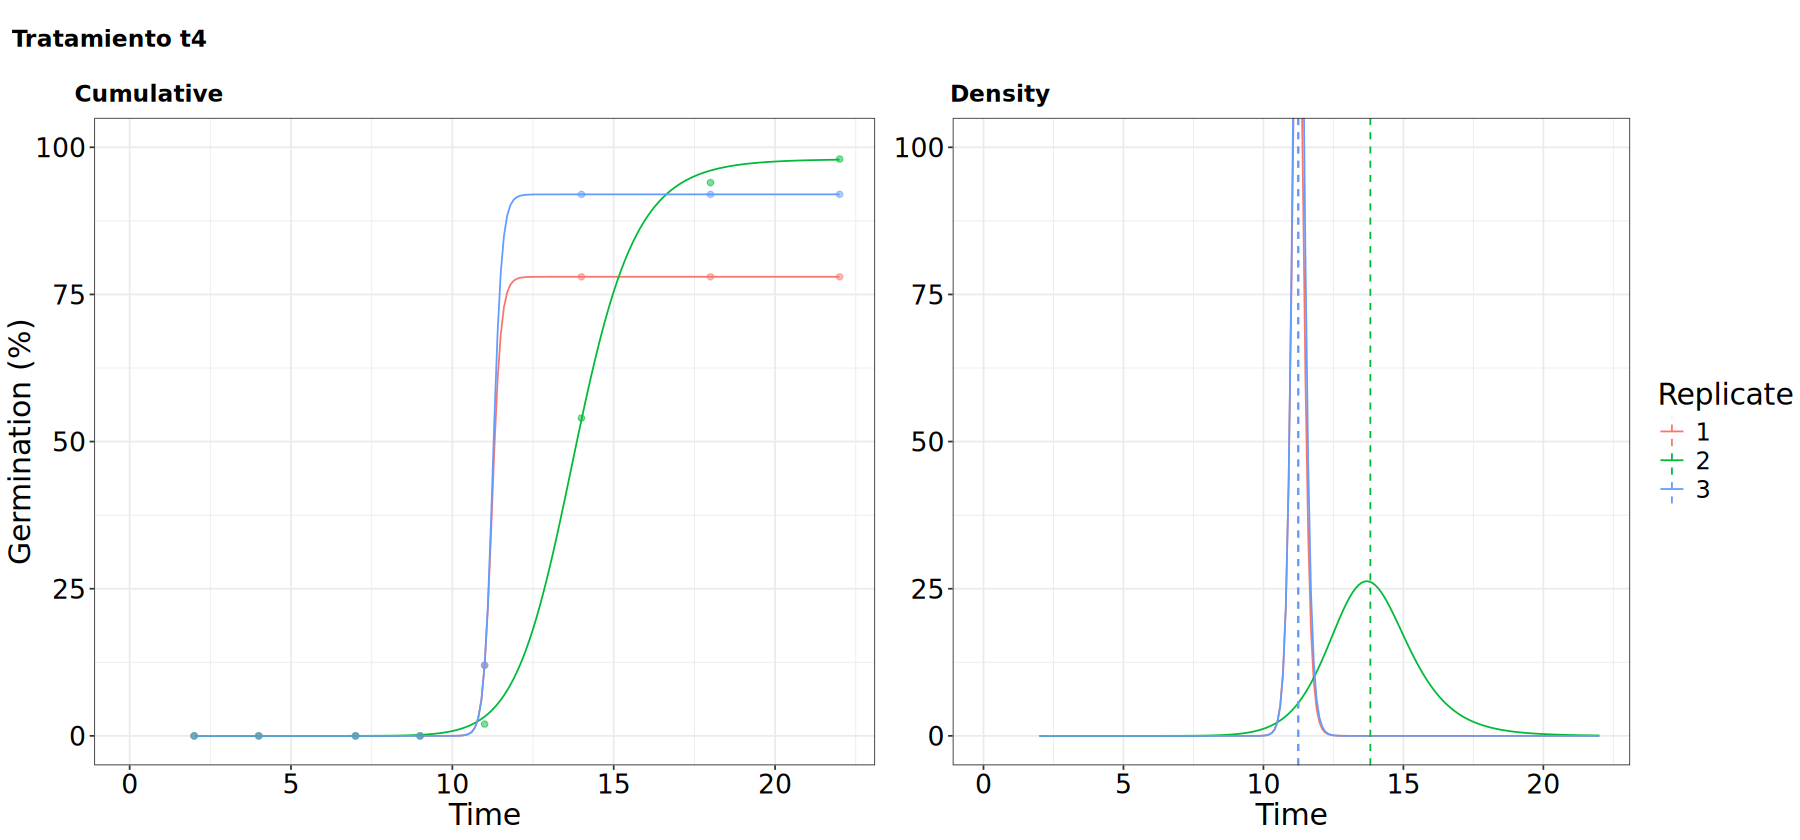

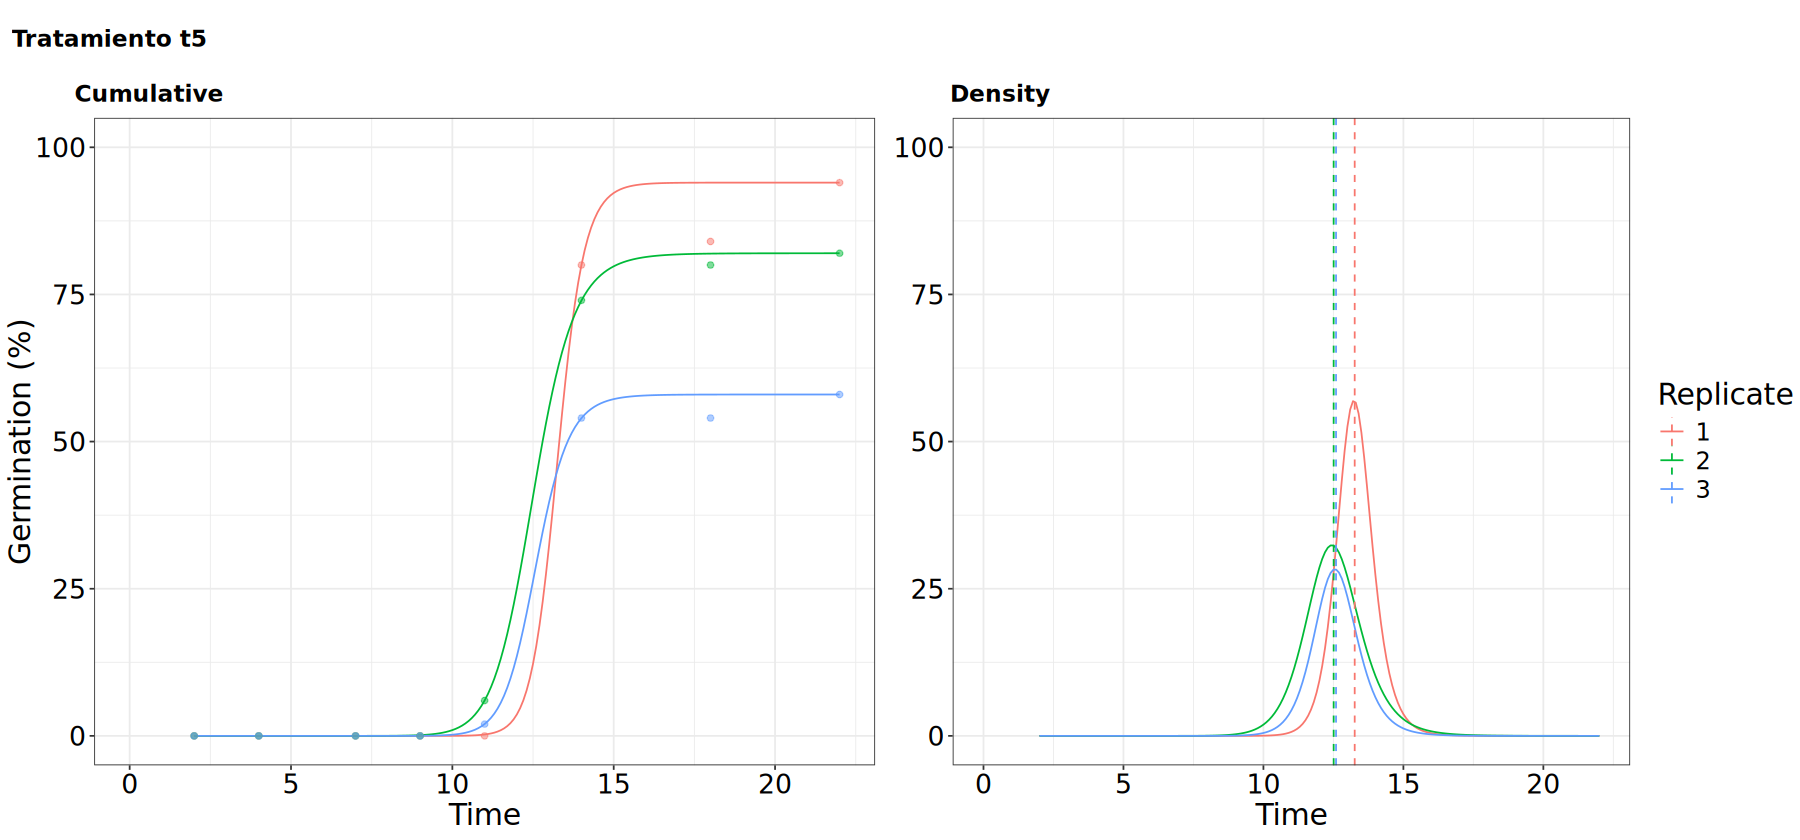

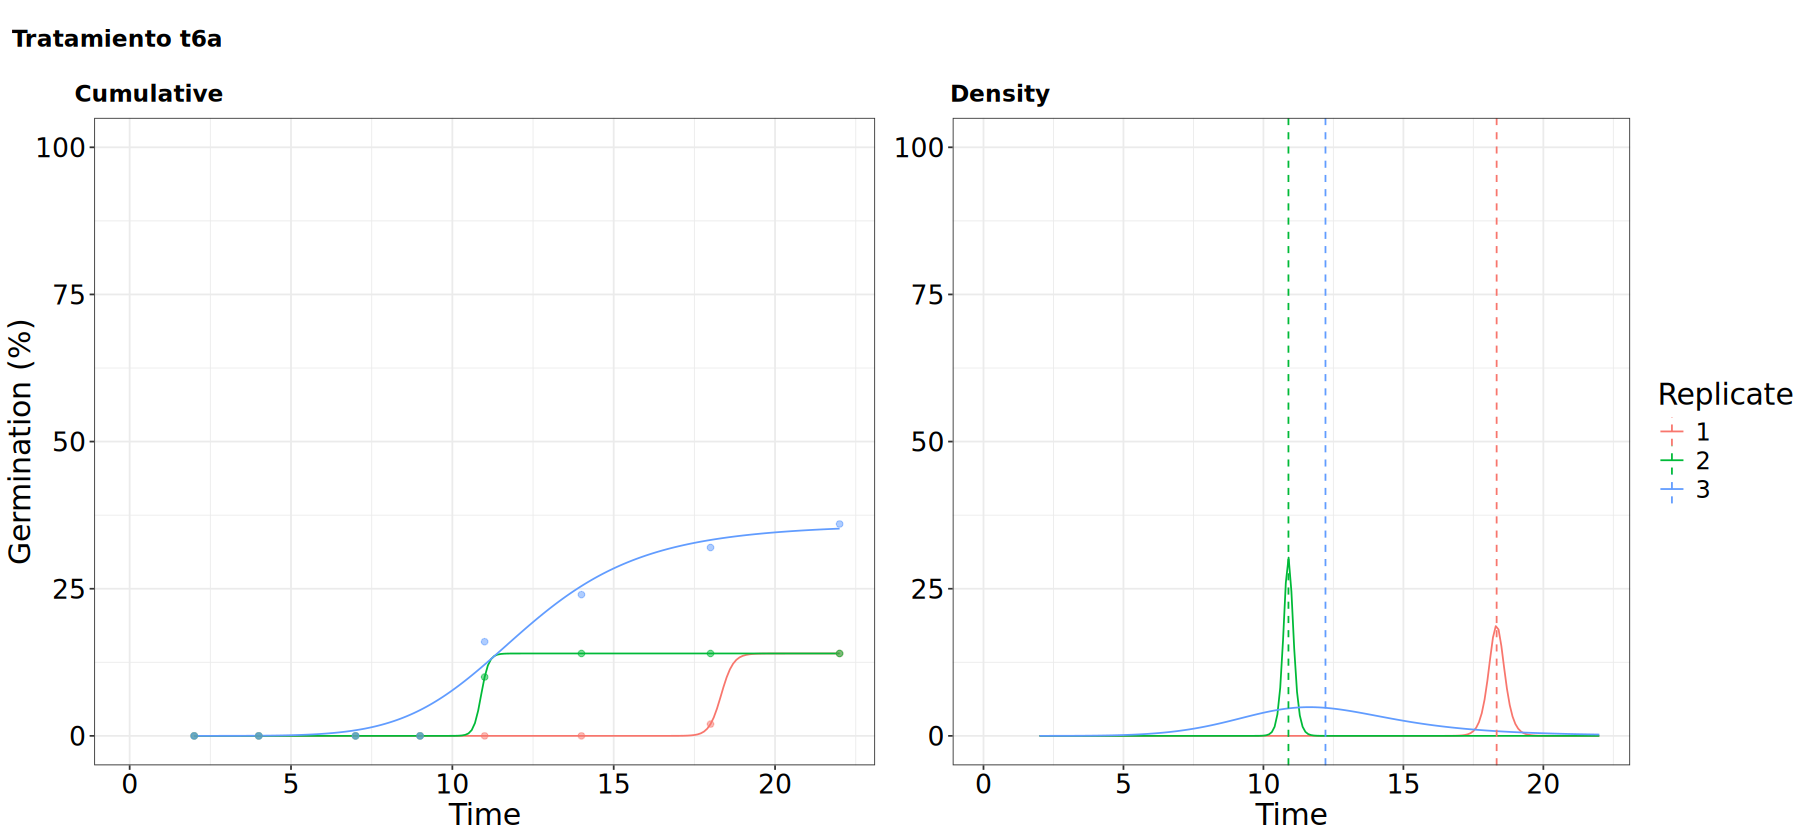

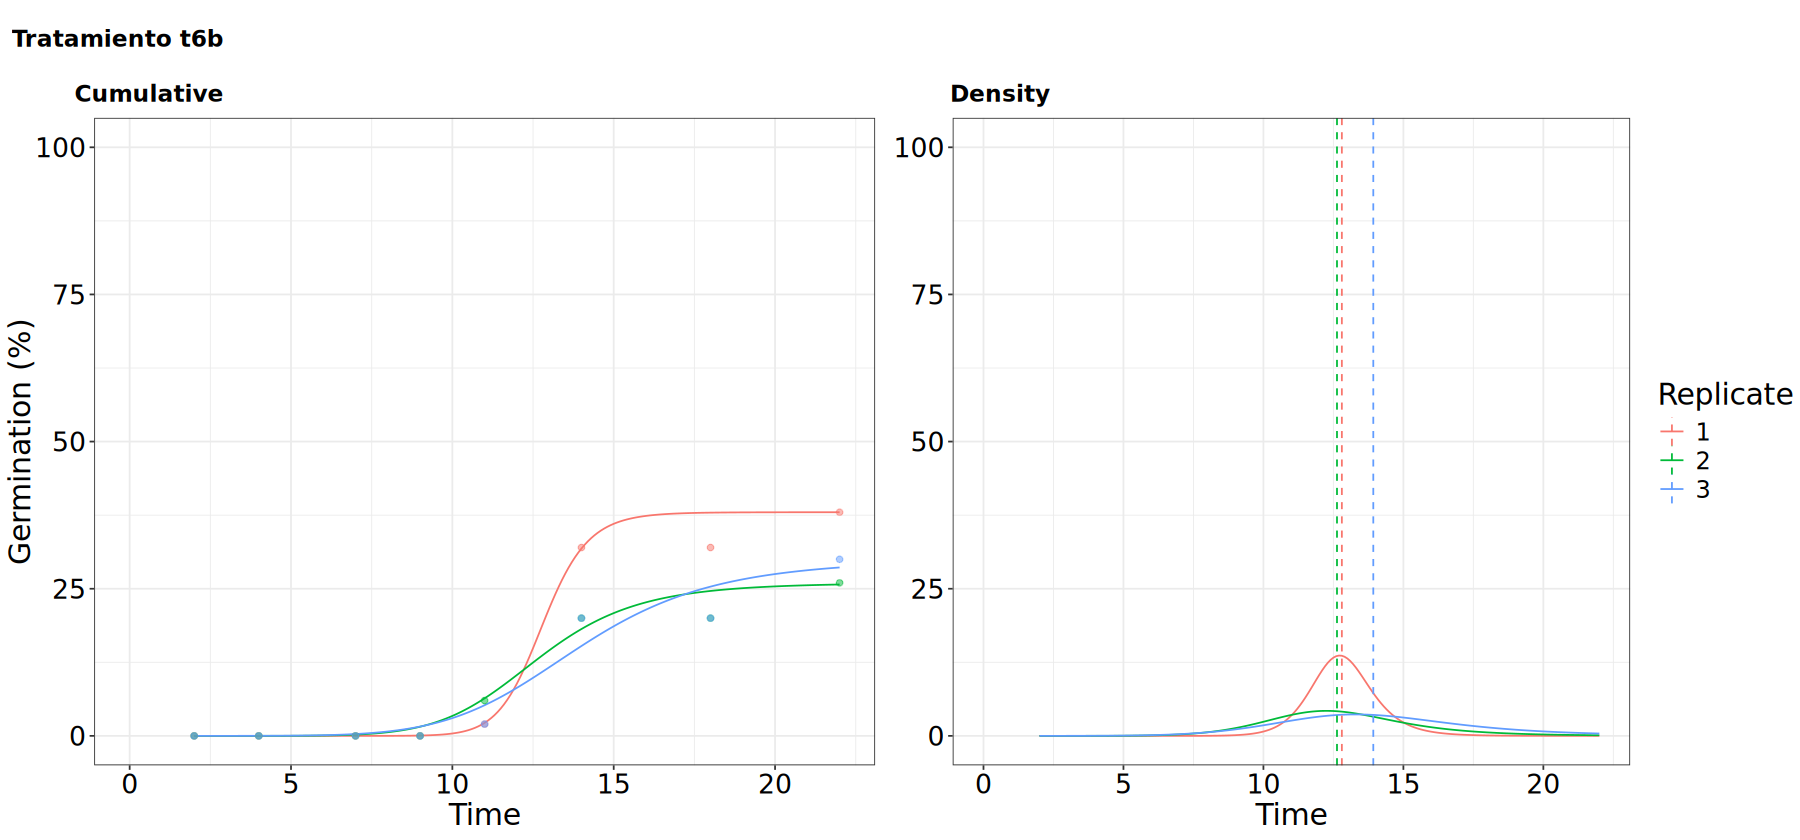

In [4]:
for (treatment in levels(fits$Treatment)) {
  p <- raw_plot_by_treatment(fits, treatment)
  print(p)
}


### 2.2. Extraer información de interés de las curvas para análisis posteriores

In [5]:
to_summarize <- get_from_fits(
  fits, param_names, time_interval_names, time_intervals
)
to_summarize


Treatment,Replicate,a,b,c,y0,t50.Germinated,Uniformity,C2,C4,C7,C9,C11,C14,C18,C22
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Control,1,90,15.581673,13.52116,0,13.52116,3.8259789,0,0,0,0,0,58,78,90
Control,2,90,15.721244,12.94619,0,12.94619,3.6305491,0,0,0,0,6,70,84,90
Control,3,92,12.272792,13.14955,0,13.14955,4.7335764,0,0,0,0,8,64,84,92
t1,1,86,24.362480,13.64646,0,13.64646,2.4648554,0,0,0,0,0,56,84,86
t1,2,70,10.119304,14.27326,0,14.27326,6.2471846,0,0,0,0,0,34,60,70
t1,3,64,11.011740,13.28902,0,13.28902,5.3385022,0,0,0,0,6,42,58,64
t2,1,76,90.085487,11.05232,0,11.05232,0.5391952,0,0,0,0,30,76,76,76
t2,2,80,81.833641,11.21042,0,11.21042,0.6020694,0,0,0,0,14,80,80,80
t2,3,64,76.782083,11.00000,0,11.00000,0.6296461,0,0,0,0,32,64,64,64


In [6]:
fits_summary <- summarize_fits(
  to_summarize,
  cols_to_exclude = c("Treatment", "Replicate")
)
cumulative_curves_df <- generate_hill_curves(
  fits_summary,
  max_time = max(time_intervals)
)

observations_df <- extract_observations(
  fits_summary,
  time_intervals
)

derivative_df <- generate_derivative_curves(
  fits_summary,
  max_time = max(time_intervals)
)
derivative_df["density"] <- round(derivative_df$derivative / 100, 5)

half_activation_df <- fits_summary[
  ,
  c(
    "Treatment",
    paste("c", statistics_prefixes[["Mean"]], sep = "")
  )
]
names(half_activation_df) <- c("Treatment", "half_activation")


## 3. Comparaciones entre tratamientos

In [7]:
filtered_statistics <- sort(paste(
  for_statistical_analysis,
  rep(statistics_prefixes, length(for_statistical_analysis)),
  sep = ""
))

fits_summary[
  ,
  c(
    "Treatment",
    filtered_statistics
  )
]


,Treatment,a.Mean,a.StdError,t50.Germinated.Mean,t50.Germinated.StdError,Uniformity.Mean,Uniformity.StdError
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Control,Control,90.66667,0.6666667,13.20563,0.16833225,4.0633681,0.33981983
t1,t1,73.33333,6.5659052,13.73625,0.28765267,4.6835140,1.13992114
t2,t2,73.33333,4.8074017,11.08758,0.06324902,0.5903036,0.02676544
t3,t3,70.66667,4.8074017,12.82397,0.20486123,4.0853349,0.27305450
t4,t4,89.33333,5.9254629,12.10188,0.85890766,1.7768920,1.17725963
t5,t5,78.00000,10.5830052,12.78815,0.23758419,2.2889153,0.28259090
t6a,t6a,21.33333,7.3333333,13.81402,2.29077569,3.2630877,2.60089235
t6b,t6b,31.33333,3.5276684,13.11840,0.40631243,6.4674408,1.84544304


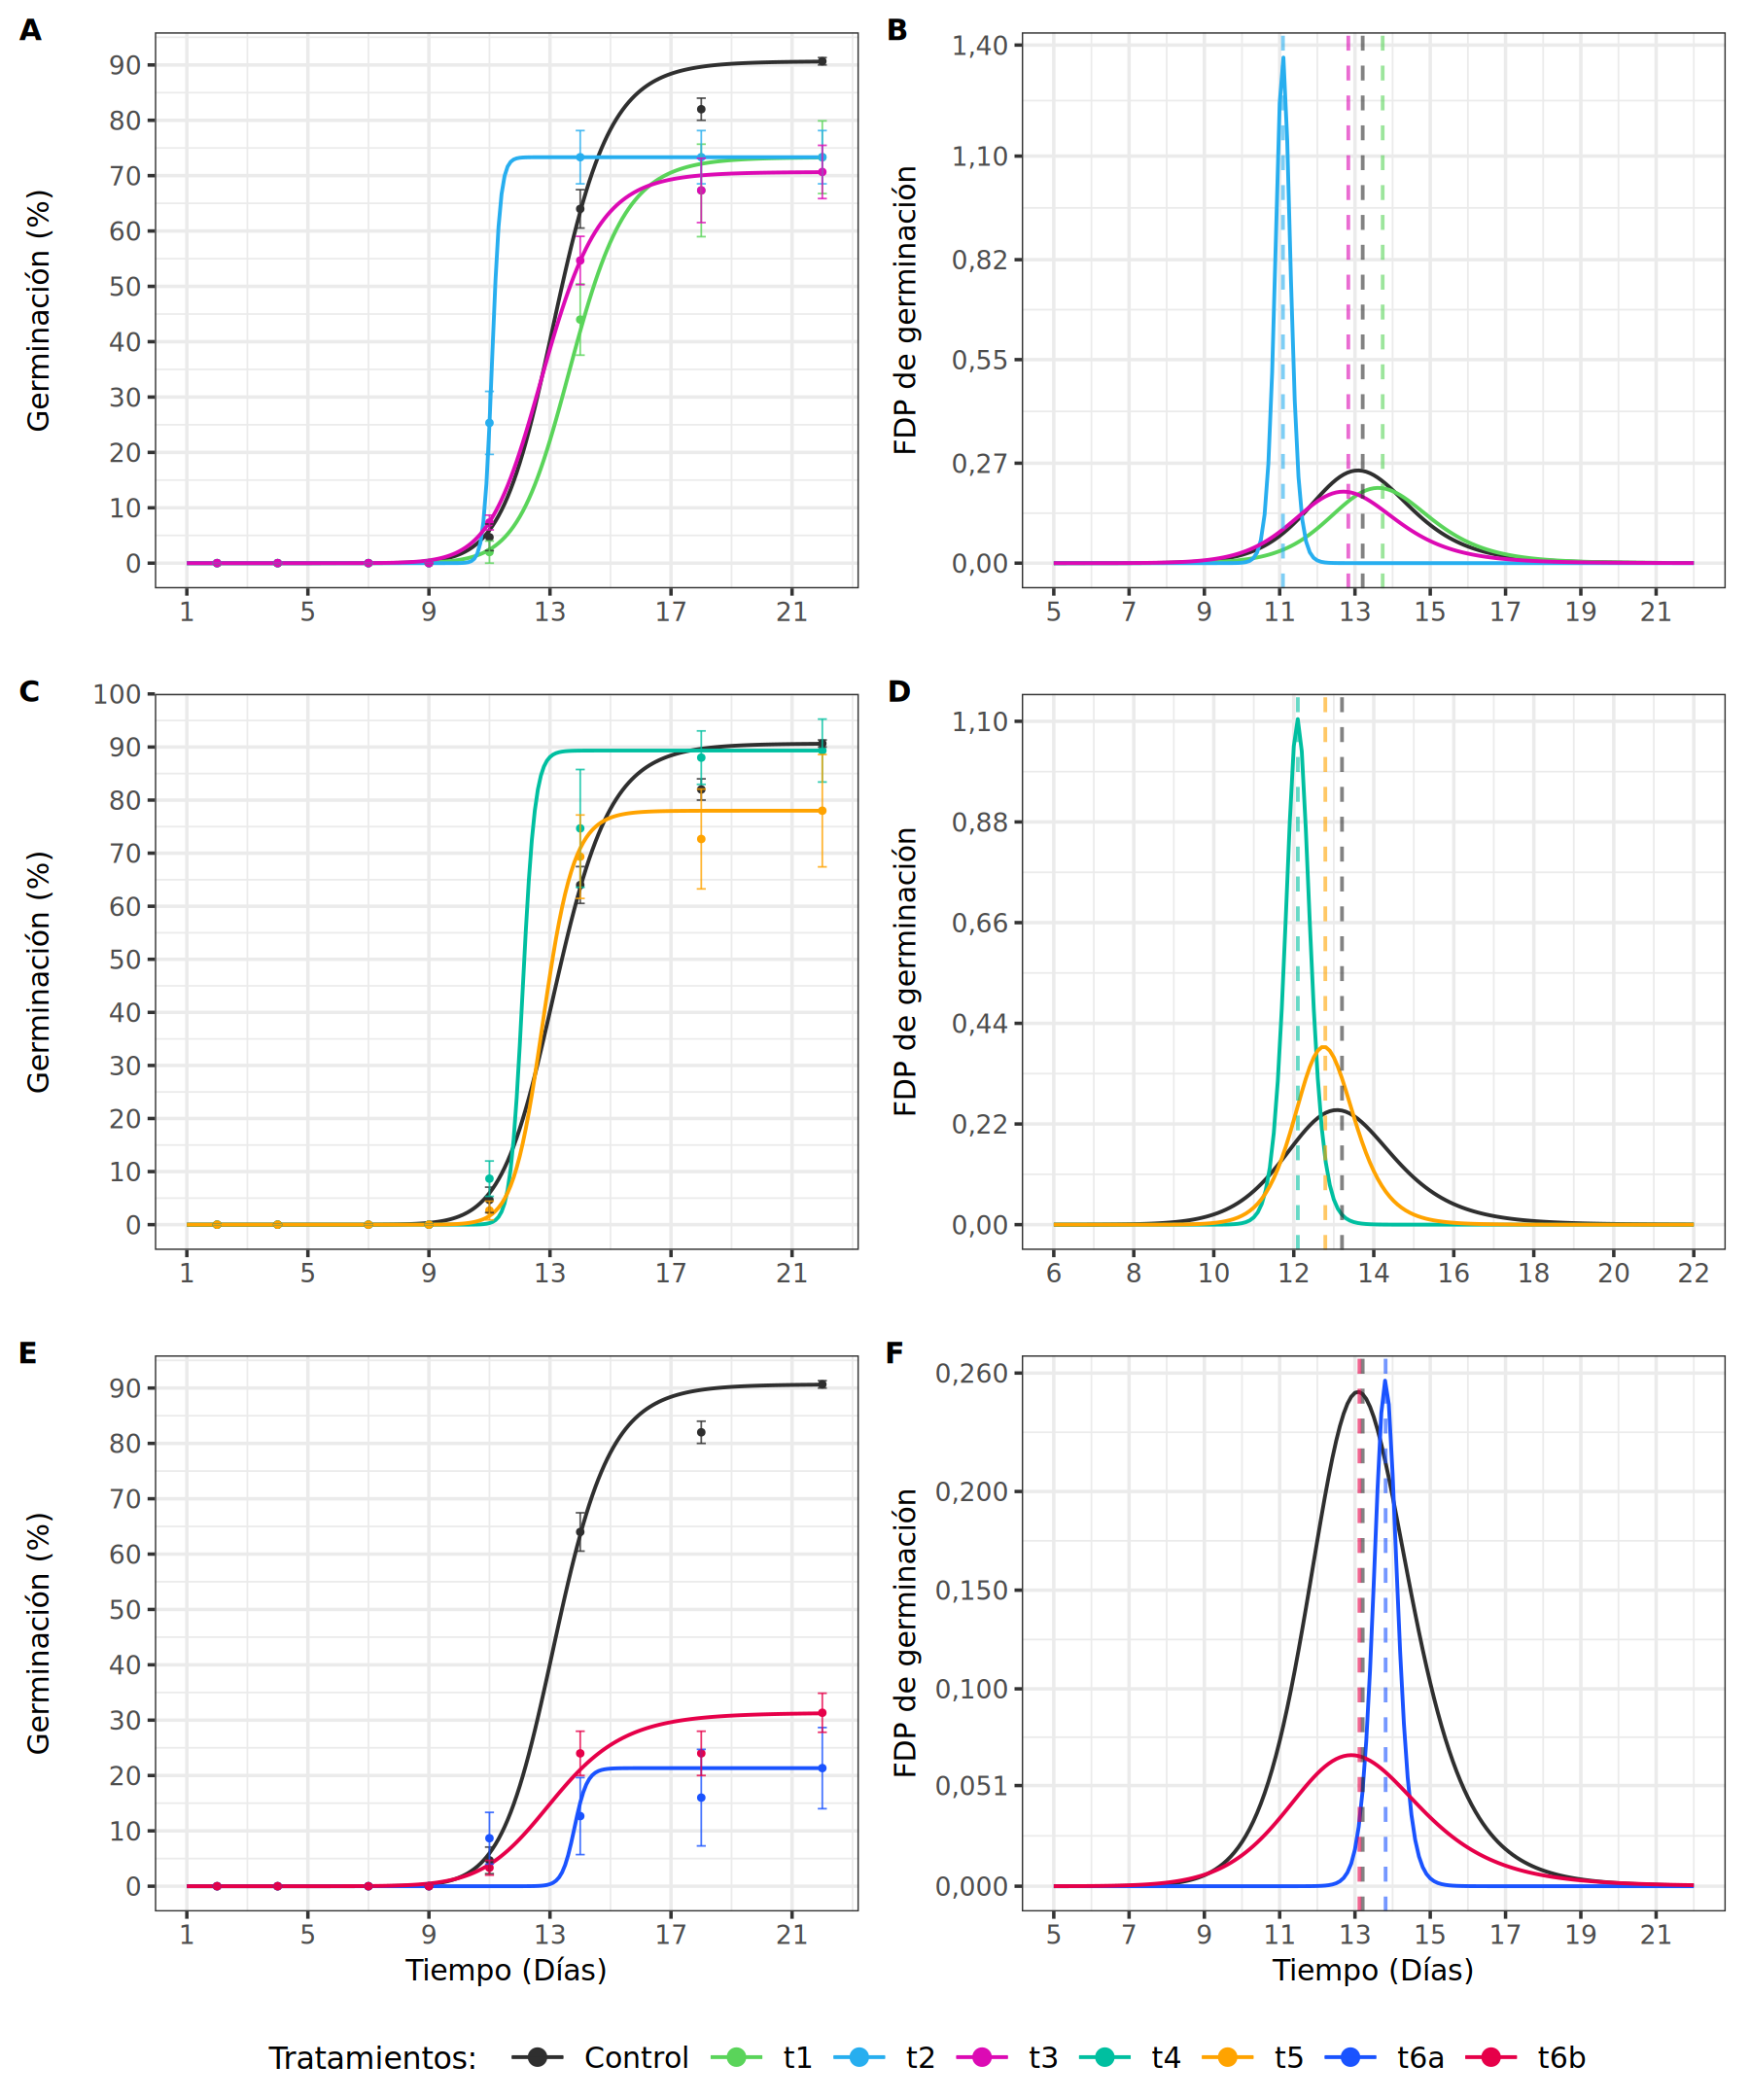

In [8]:
old_plot_height <- options(repr.plot.height = 18)

all_comparisons_plot(
  cumulative_curves_df, observations_df,
  derivative_df, half_activation_df,
  comparisons, treatment_colors
)
options(repr.plot.height = old_plot_height)


In [9]:
test_outputs <- vector(mode = "list", length = length(comparisons))
names(test_outputs) <- names(comparisons)

for (treatment_name in names(comparisons)) {
  test_outputs[[treatment_name]] <- list()
  cat(sprintf("❗ '%s':\n", treatment_name))
  for (response in for_statistical_analysis) {
    cat(sprintf("\t▶ Running for '%s'...", response))
    test_outputs[[treatment_name]][[response]] <- treatments_differences(
      to_summarize[
        to_summarize$Treatment %in% comparisons[[treatment_name]],
      ],
      response
    )
    cat("\n\t\tDone!\n")
  }
}


❗ 'scarification':
	▶ Running for 'a'...
		Done!
	▶ Running for 't50.Germinated'...
		Done!
	▶ Running for 'Uniformity'...
		Done!
❗ 'temperature':
	▶ Running for 'a'...
		Done!
	▶ Running for 't50.Germinated'...
		Done!
	▶ Running for 'Uniformity'...
		Done!
❗ 'light':
	▶ Running for 'a'...
		Done!
	▶ Running for 't50.Germinated'...
		Done!
	▶ Running for 'Uniformity'...
		Done!


In [10]:
print_summaries <- function(single_response_output) {
  cat("▶ One way ANOVA\n\n")
  print(summary(single_response_output[["anova"]]))
  cat("\n\n▶ Multiple comparisons\n\n")
  print(summary(single_response_output[["Tukey"]]))
}


### 3.1. Pruebas de escarificación
#### 3.1.1. Tasa de germinación


In [11]:
print_summaries(test_outputs[["scarification"]][["t50.Germinated"]])


▶ One way ANOVA

            Df Sum Sq Mean Sq F value   Pr(>F)    
Treatment    3 11.832   3.944   33.48 7.07e-05 ***
Residuals    8  0.942   0.118                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


▶ Multiple comparisons


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = as.formula(paste(response, "~", "Treatment")), 
    data = fitted_df)

Linear Hypotheses:
                  Estimate Std. Error t value Pr(>|t|)    
t1 - Control == 0   0.5306     0.2802   1.894  0.30259    
t2 - Control == 0  -2.1181     0.2802  -7.558  < 0.001 ***
t3 - Control == 0  -0.3817     0.2802  -1.362  0.55350    
t2 - t1 == 0       -2.6487     0.2802  -9.452  < 0.001 ***
t3 - t1 == 0       -0.9123     0.2802  -3.256  0.04660 *  
t3 - t2 == 0        1.7364     0.2802   6.197  0.00116 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step met

#### 3.1.2.Uniformidad


In [12]:
print_summaries(test_outputs[["scarification"]][["Uniformity"]])


▶ One way ANOVA

            Df Sum Sq Mean Sq F value  Pr(>F)   
Treatment    3 31.331  10.444   9.344 0.00542 **
Residuals    8  8.941   1.118                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


▶ Multiple comparisons


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = as.formula(paste(response, "~", "Treatment")), 
    data = fitted_df)

Linear Hypotheses:
                  Estimate Std. Error t value Pr(>|t|)   
t1 - Control == 0  0.62015    0.86318   0.718  0.88709   
t2 - Control == 0 -3.47306    0.86318  -4.024  0.01595 * 
t3 - Control == 0  0.02197    0.86318   0.025  0.99999   
t2 - t1 == 0      -4.09321    0.86318  -4.742  0.00657 **
t3 - t1 == 0      -0.59818    0.86318  -0.693  0.89700   
t3 - t2 == 0       3.49503    0.86318   4.049  0.01529 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



#### 3.1.3. Viabilidad y dormancia

In [13]:
print_summaries(test_outputs[["scarification"]][["a"]])


▶ One way ANOVA

            Df Sum Sq Mean Sq F value Pr(>F)  
Treatment    3  761.3  253.78   3.769 0.0592 .
Residuals    8  538.7   67.33                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


▶ Multiple comparisons


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = as.formula(paste(response, "~", "Treatment")), 
    data = fitted_df)

Linear Hypotheses:
                    Estimate Std. Error t value Pr(>|t|)  
t1 - Control == 0 -1.733e+01  6.700e+00  -2.587   0.1190  
t2 - Control == 0 -1.733e+01  6.700e+00  -2.587   0.1190  
t3 - Control == 0 -2.000e+01  6.700e+00  -2.985   0.0677 .
t2 - t1 == 0       3.553e-15  6.700e+00   0.000   1.0000  
t3 - t1 == 0      -2.667e+00  6.700e+00  -0.398   0.9772  
t3 - t2 == 0      -2.667e+00  6.700e+00  -0.398   0.9772  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



### 3.2. Pruebas de temperatura
#### 3.2.1. Tasa de germinación

In [14]:
print_summaries(test_outputs[["temperature"]][["t50.Germinated"]])


▶ One way ANOVA

            Df Sum Sq Mean Sq F value Pr(>F)
Treatment    2  1.864  0.9318   1.133  0.382
Residuals    6  4.935  0.8225               


▶ Multiple comparisons


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = as.formula(paste(response, "~", "Treatment")), 
    data = fitted_df)

Linear Hypotheses:
                  Estimate Std. Error t value Pr(>|t|)
t4 - Control == 0  -1.1037     0.7405  -1.491    0.359
t5 - Control == 0  -0.4175     0.7405  -0.564    0.844
t5 - t4 == 0        0.6863     0.7405   0.927    0.645
(Adjusted p values reported -- single-step method)



#### 3.2.2.Uniformidad

In [15]:
print_summaries(test_outputs[["temperature"]][["Uniformity"]])


▶ One way ANOVA

            Df Sum Sq Mean Sq F value Pr(>F)
Treatment    2  8.639   4.319   2.732  0.143
Residuals    6  9.488   1.581               


▶ Multiple comparisons


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = as.formula(paste(response, "~", "Treatment")), 
    data = fitted_df)

Linear Hypotheses:
                  Estimate Std. Error t value Pr(>|t|)
t4 - Control == 0   -2.287      1.027  -2.227    0.144
t5 - Control == 0   -1.774      1.027  -1.728    0.271
t5 - t4 == 0         0.512      1.027   0.499    0.875
(Adjusted p values reported -- single-step method)



#### 3.2.3. Viabilidad y dormancia

In [16]:
print_summaries(test_outputs[["temperature"]][["a"]])


▶ One way ANOVA

            Df Sum Sq Mean Sq F value Pr(>F)
Treatment    2  290.7   145.3   0.985  0.427
Residuals    6  885.3   147.6               


▶ Multiple comparisons


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = as.formula(paste(response, "~", "Treatment")), 
    data = fitted_df)

Linear Hypotheses:
                  Estimate Std. Error t value Pr(>|t|)
t4 - Control == 0   -1.333      9.918  -0.134    0.990
t5 - Control == 0  -12.667      9.918  -1.277    0.457
t5 - t4 == 0       -11.333      9.918  -1.143    0.525
(Adjusted p values reported -- single-step method)



### 3.3. Pruebas efecto de la luz
#### 3.3.1. Tasa de germinación


In [17]:
print_summaries(test_outputs[["light"]][["t50.Germinated"]])


▶ One way ANOVA

            Df Sum Sq Mean Sq F value Pr(>F)
Treatment    2   0.86   0.431   0.079  0.925
Residuals    6  32.65   5.441               


▶ Multiple comparisons


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = as.formula(paste(response, "~", "Treatment")), 
    data = fitted_df)

Linear Hypotheses:
                   Estimate Std. Error t value Pr(>|t|)
t6a - Control == 0  0.60839    1.90457   0.319    0.946
t6b - Control == 0 -0.08722    1.90457  -0.046    0.999
t6b - t6a == 0     -0.69562    1.90457  -0.365    0.930
(Adjusted p values reported -- single-step method)



#### 3.3.2.Uniformidad

In [18]:
print_summaries(test_outputs[["light"]][["Uniformity"]])


▶ One way ANOVA

            Df Sum Sq Mean Sq F value Pr(>F)
Treatment    2  16.69   8.344   0.811  0.488
Residuals    6  61.71  10.286               


▶ Multiple comparisons


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = as.formula(paste(response, "~", "Treatment")), 
    data = fitted_df)

Linear Hypotheses:
                   Estimate Std. Error t value Pr(>|t|)
t6a - Control == 0  -0.8003     2.6186  -0.306    0.950
t6b - Control == 0   2.4041     2.6186   0.918    0.650
t6b - t6a == 0       3.2044     2.6186   1.224    0.483
(Adjusted p values reported -- single-step method)



#### 3.3.3. Viabilidad y dormancia

In [19]:
print_summaries(test_outputs[["light"]][["a"]])


▶ One way ANOVA

            Df Sum Sq Mean Sq F value  Pr(>F)    
Treatment    2   8428    4214   63.21 9.3e-05 ***
Residuals    6    400      67                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


▶ Multiple comparisons


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = as.formula(paste(response, "~", "Treatment")), 
    data = fitted_df)

Linear Hypotheses:
                   Estimate Std. Error t value Pr(>|t|)    
t6a - Control == 0  -69.333      6.667   -10.4   <0.001 ***
t6b - Control == 0  -59.333      6.667    -8.9   <0.001 ***
t6b - t6a == 0       10.000      6.667     1.5    0.355    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



## 4. Viabilidad

Semillas viables: 62% ± 20% IC95%

## 5. Curva imbibición

In [5]:
imbibition_data <- data.frame(
  Replicate = as.factor(sort(rep(c("1", "2", "3"), 5))),
  Time = as.factor(rep(c(0, 1, 2, 3, 4), 3)),
  Weight = c(
    0.15, 0.23, 0.25, 0.26, 0.28,
    0.17, 0.26, 0.28, 0.30, 0.31,
    0.16, 0.24, 0.26, 0.28, 0.28
  )
)

add_cumulative_percent <- function(imbibition_data) {
  weight_percentage <- c()
  weight_reference <- 0
  for (i in seq_len(nrow(imbibition_data))) {
    if (imbibition_data[i, "Time"] == 0) {
      weight_reference <- imbibition_data[i, "Weight"]
    }
    weight_percentage <- c(
      weight_percentage,
      round(
        100 *
          (imbibition_data[i, "Weight"] - weight_reference) / weight_reference,
        5
      )
    )
  }
  cbind(imbibition_data, Weight_percent = weight_percentage)
}

summarize_imbibition_data <- function(
    imbibition_data, col_name = "Weight_percent") {
  imbibition_summary <- data.frame()
  for (l in levels(imbibition_data$Time)) {
    level_wp <- imbibition_data[imbibition_data$Time == l, col_name]
    mean_wp <- mean(level_wp)
    std_error_wp <- sd(level_wp) / sqrt(length(level_wp))
    imbibition_summary <- rbind(
      imbibition_summary,
      data.frame(
        Time = as.integer(l),
        WeightPercent.Mean = mean_wp,
        WeightPercent.StdErr = std_error_wp
      )
    )
  }
  imbibition_summary
}


In [6]:
imbibition_summary <- summarize_imbibition_data(
  add_cumulative_percent(imbibition_data)
)


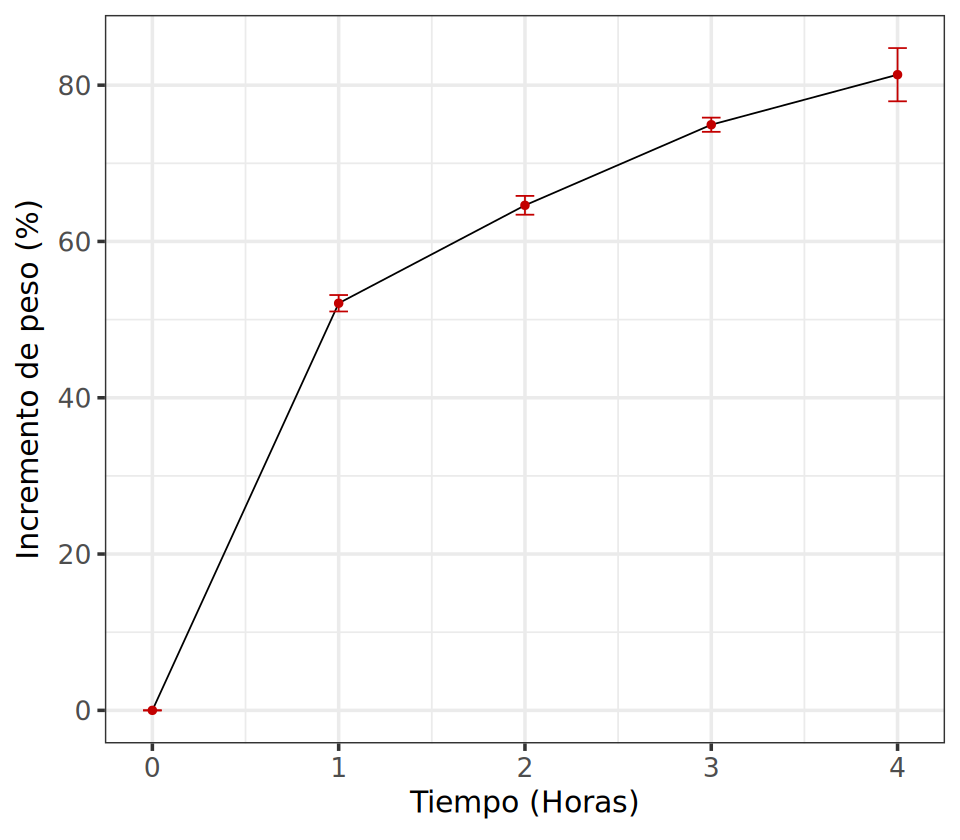

In [7]:
old_plot_width <- options(repr.plot.width = 8)

ggplot(
  data = imbibition_summary,
  mapping = aes(x = Time, y = WeightPercent.Mean)
) +
  geom_line(linewidth = 0.5) +
  geom_point(size = 2, color = "#c30000", ) +
  geom_errorbar(
    color = "#c30000",
    width = 0.1,
    mapping = aes(
      ymin = WeightPercent.Mean - WeightPercent.StdErr,
      ymax = WeightPercent.Mean + WeightPercent.StdErr
    )
  ) +
  labs(
    x = expression("Tiempo" ~ "(Horas)"),
    y = expression("Incremento de peso" ~ "(%)")
  )


In [8]:
sessionInfo()


R version 4.3.3 (2024-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 24.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.12.0 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: America/Bogota
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] germinationmetrics_0.1.8 multcomp_1.4-26          TH.data_1.1-2           
 [4] MASS_7.3-60.0.1          survival_3.7-0           mvtnorm_1.2-5           
 [7] gtable_0.3.5             scales_1.3.0             cowplot_1.1.3           
[10] ggplot2_3.5.1        